# Supervised Learning - Project

In this Project, we are going to perform a full unsupervised learning machine learning project on a "Wholesale Data" dataset. The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

[Kaggle Link](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set)

# Part I : EDA - Exploratory Data Analysis & Pre-processing

The given dataset seems to be a grocery sales dataset containing information about various products sold by a grocery store. To perform an exploratory data analysis (EDA) on this dataset, we can perform the following tasks:

- Data Import: Import the dataset into a statistical software tool such as Python or R.
- Data Cleaning: Check the dataset for any missing or incorrect data and clean the dataset accordingly. This may involve removing or imputing missing data or correcting any obvious errors.
Data Description: Generate summary statistics such as mean, median, and standard deviation for each column of the dataset. This will help in understanding the distribution of data in each column.
- Data Visualization: Create various visualizations such as histograms, box plots, scatter plots, and heatmaps to understand the relationships and trends between the different variables in the dataset. For example, we can create a scatter plot between the "Fresh" and "Milk" variables to see if there is any correlation between them.
- Outlier Detection: Check for any outliers in the dataset and determine whether they are valid or erroneous data points.
- Correlation Analysis: Calculate the correlation between different variables in the dataset to determine which variables are highly correlated and which ones are not. For example, we can calculate the correlation between "Grocery" and "Detergents_Paper" to see if there is any relationship between these two variables.
- Data Transformation: If necessary, transform the data by standardizing or normalizing the variables to make them comparable across different scales.
- Feature Selection: Identify the most important features or variables that contribute the most to the overall variance in the dataset. This can be done using various feature selection techniques such as principal component analysis (PCA) or random forest regression.

In [115]:
# Imports
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score, mean_squared_error
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
# Import dataset into a DataFrame
wholesale = pd.read_csv('Wholesale_Data.csv')

# Display basic information about the dataset
print(wholesale.info())

# Display summary statistics of numerical features
print("\n",wholesale.describe())

# Display the first few rows of the dataset
print("\n", wholesale.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None

           Channel      Region          Fresh          Milk       Grocery  \
count  440.000000  440.000000     440.000000    440.000000    440.000000   
mean     1.322727    2.543182   12000.297727   5796.265909   7951.277273   
std      0.468052    0.774272   12647.328865   7380.377175   9503.162829   
min      1.000000    1.000000       3.000000     55.000000      3.000000   
25%      1.000000   

The dataset consists exclusively of numeric columns.
There are no missing values in the dataset. However, it seems there are many outliers in the dataset. Use data visualization to determine if outlier handling is required.

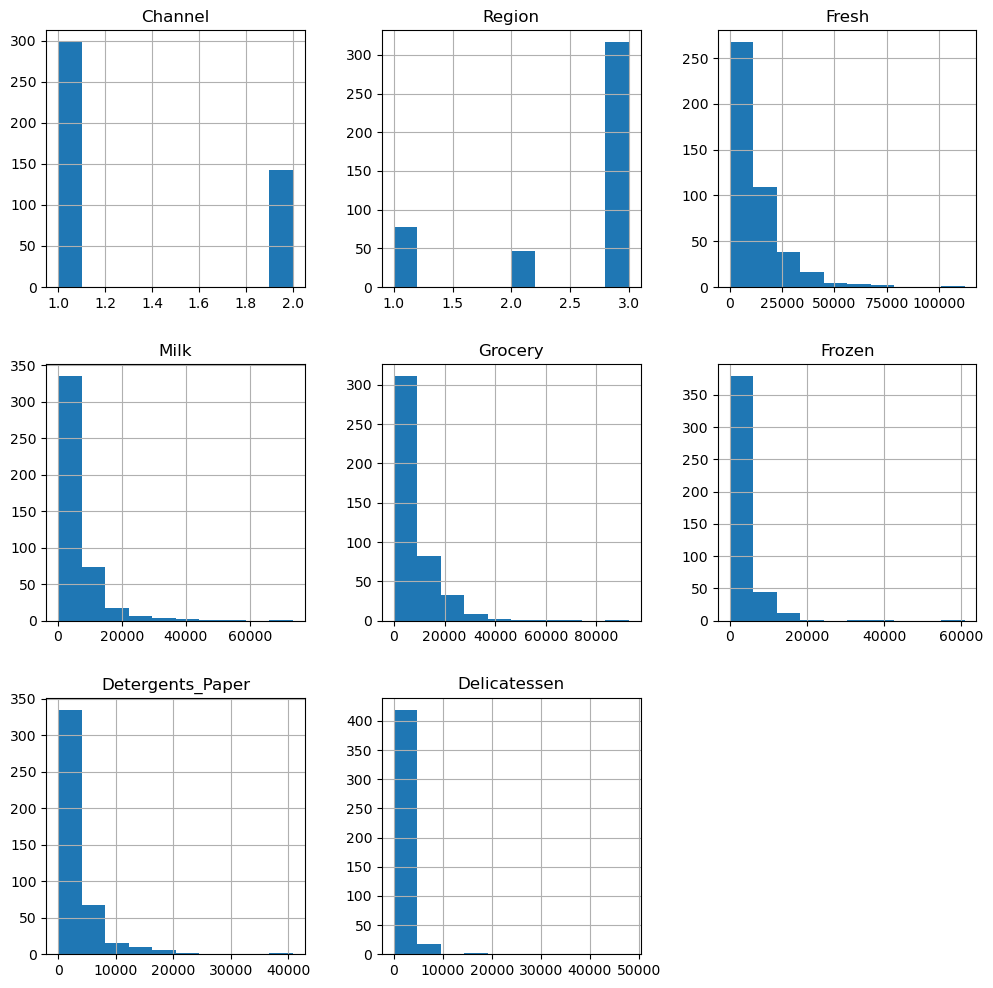

In [3]:
# correct the name of column "Delicassen"
wholesale.rename(columns={'Delicassen': 'Delicatessen'}, inplace=True)

# Display histograms for numerical features
wholesale.hist(figsize=(12, 12))
plt.show()


There are a few outliers in most columns, except for "Channel" and "Region". Due to the nature of these columns and their distribution being skewed right, outliers will be removed based on the 3*IQR instead of 1.5

In [4]:
# Remove rows containing outliers

# Calculate first and third quartiles for each column
Q1 = wholesale.quantile(0.25)
Q3 = wholesale.quantile(0.75)

# Calculate IQR and set the upper and lower limits for each column
IQR = Q3 - Q1
lower_limit = Q1 - 3 * IQR
upper_limit = Q3 + 3 * IQR

# Identify outliers in each column
outliers = ((wholesale < lower_limit) | (wholesale > upper_limit)).any(axis=1)

# Remove rows containing outliers
sales = wholesale[~outliers]

# Display summary of resulting dataframe
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 402 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           402 non-null    int64
 1   Region            402 non-null    int64
 2   Fresh             402 non-null    int64
 3   Milk              402 non-null    int64
 4   Grocery           402 non-null    int64
 5   Frozen            402 non-null    int64
 6   Detergents_Paper  402 non-null    int64
 7   Delicatessen      402 non-null    int64
dtypes: int64(8)
memory usage: 28.3 KB


38 rows (8.6% of the dataset) were removed for containing outliers.

Next, the dataset must be scaled to bring product columns in line with "Channel" and "Region".

In [5]:
# Scale the dataset columns
scaler = MinMaxScaler()
scaled = scaler.fit_transform(sales)

# Convert scaled dataset back to a DataFrame
scaled_sales= pd.DataFrame(scaled, columns=sales.columns)

C:\Users\mario\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


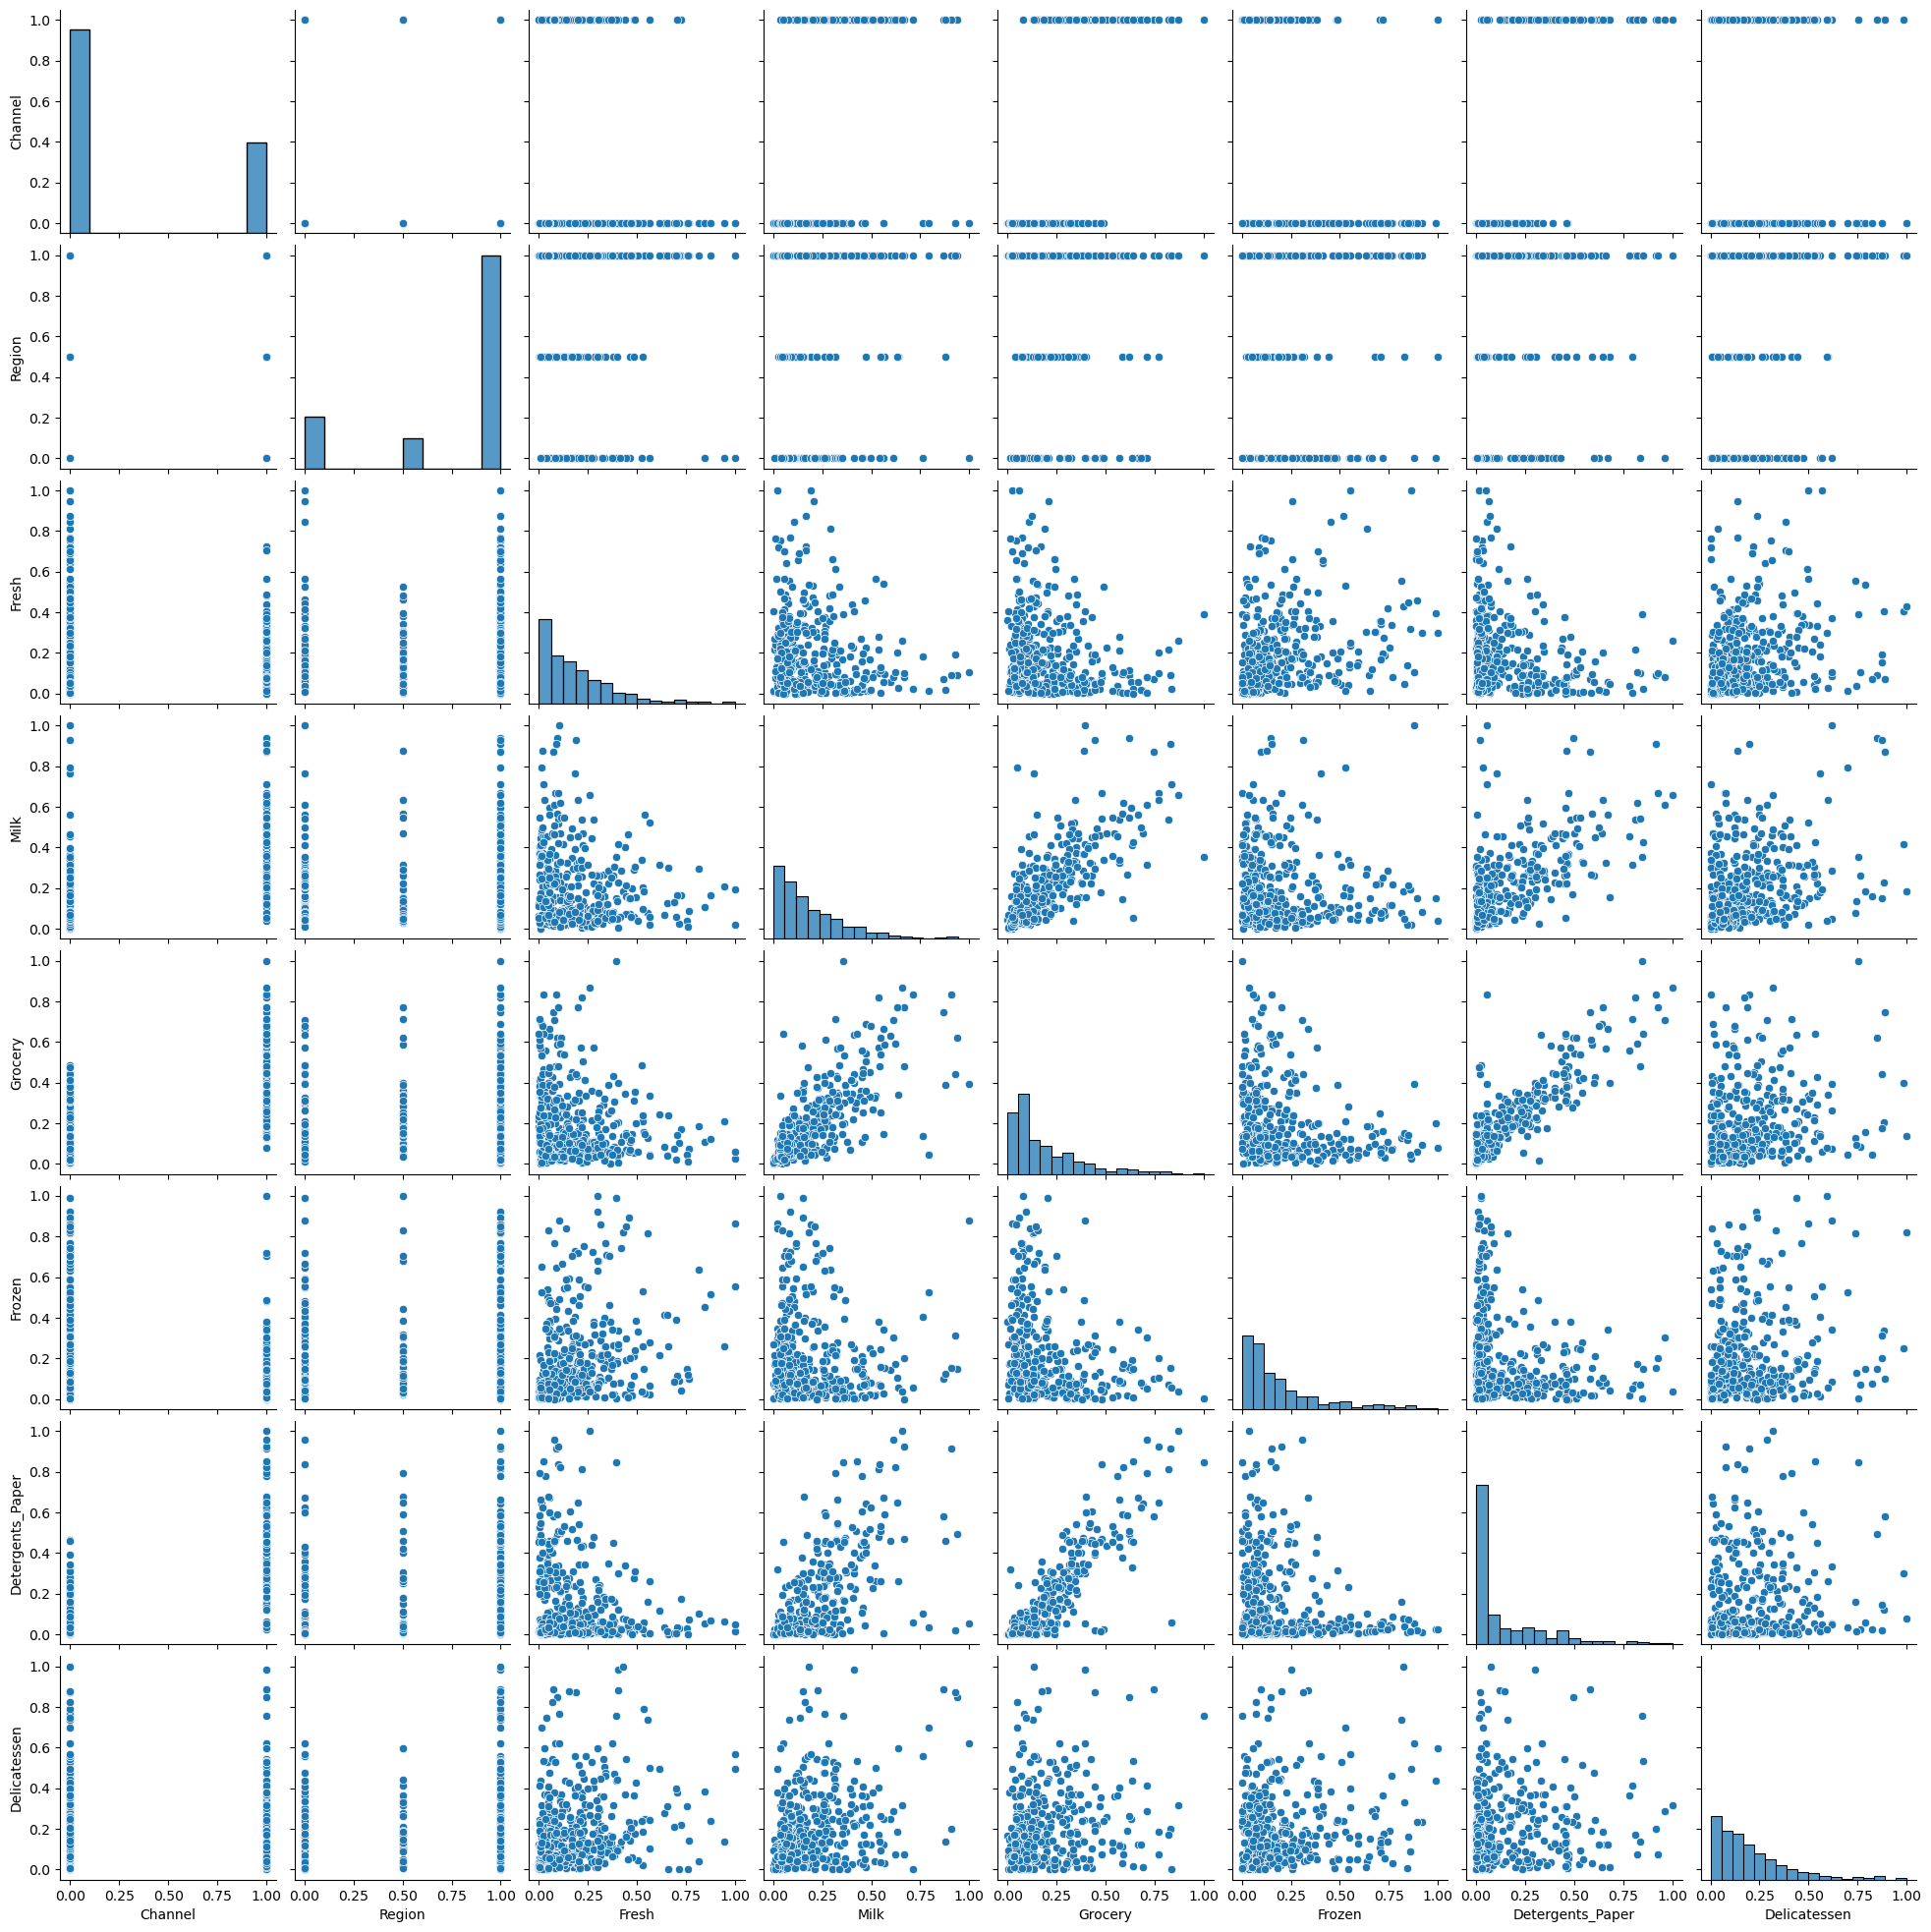

In [6]:
# Use visualization to investigate relationships between columns
sns.pairplot(scaled_sales)
plt.show()

It seems there are strong correlations between "Milk", "Grocery" and "Detergents_Paper". Let's create a correlation matrix to investigate these correlations.

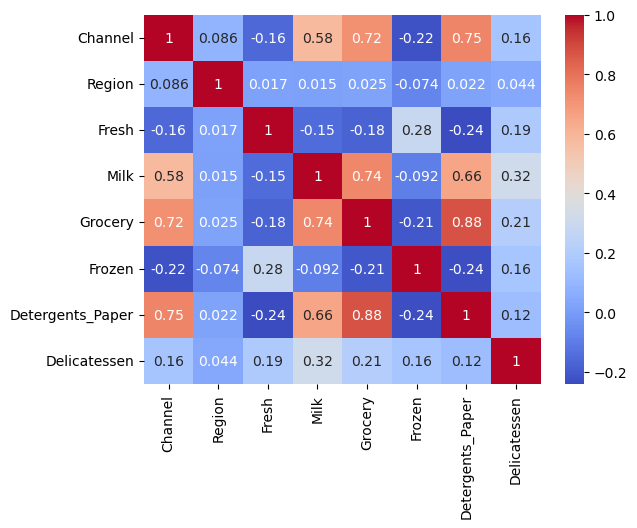

In [7]:
# Create and display a correlation matrix
correlation = scaled_sales.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

Correlation between the scaled columns "Milk", "Grocery" and "Detergents_Paper" range between 0.66 and 0.88. Additionally, the correlation matrix also revealed a strong correlation to the scaled "Channel" column, which was not obvious from the pairplots.

Now that the dataset has been cleaned and scaled, it is ready for further analysis using unsupervised machine learning methods

# Part II - KMeans Clustering

The objective of the analysis is to group similar products together into clusters based on their attributes such as fresh, milk, grocery, frozen, detergents_paper, and delicatessen. To perform the k-means clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters, initialize the centroids, assign data points to clusters, update the centroids, and repeat until convergence.

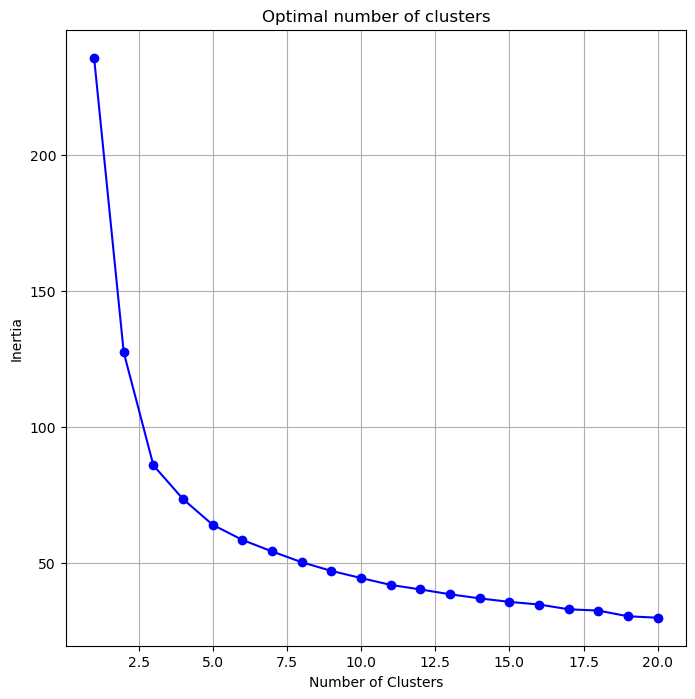

In [21]:
# Using the elbow method, determine the ideal number of clusters for the KMeans algorithm

# Initialize variables and parameters
inertia = []
clusters_range = range(1, 21)

# Fit KMeans for each value of k and record inertia values
with warnings.catch_warnings():
    warnings.filterwarnings("ignore") # Ignore warnings for improved readability.
    for k in clusters_range:
        kmeans_sales = KMeans(n_clusters=k, random_state=0)
        kmeans_sales.fit(scaled_sales)
        inertia.append(kmeans_sales.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 8))
plt.plot(clusters_range, inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Optimal number of clusters')
plt.grid(True)
plt.show()

From the graph it is not completely clear what is the optimal number of clusters for this dataset, however, it appears the optimal number is between 5 and 8. For the rest of the analysis, 6 clusters will be used.
Now let's analyze the output of KMeans

In [112]:
# Fit KMeans with 6 clusters
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kmeans_sales = KMeans(n_clusters=6, random_state=0)
    kmeans_sales.fit(scaled_sales)

# Count the number of points in each cluster
cluster_labels = kmeans_sales.labels_
cluster_counts = Counter(cluster_labels)


# Find the coordinates of the cluster centroids
centroids = kmeans_sales.cluster_centers_

# Reverse scaling of cluster centroids values
centroids_unscaled = scaler.inverse_transform(centroids)

# Create a dataframe with the output of KMeans for easier visualization of the results
KMeans_df =pd.DataFrame(centroids_unscaled, columns=sales.columns)
KMeans_df['Count']=list(cluster_counts.values())
KMeans_df['Percent']=KMeans_df['Count']*100/KMeans_df['Count'].sum()
KMeans_df['Cluster_Labels']=cluster_counts.keys()
KMeans_df.set_index('Cluster_Labels', inplace=True)
KMeans_df.sort_index(inplace=True)
KMeans_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Count,Percent
Cluster_Labels,,,,,,,,,,
0,2.0,3.000000,10213.128571,6741.071429,10317.114286,1389.071429,4269.400000,1433.600000,55,13.681592
1,1.0,2.945455,19037.490909,4156.945455,3942.909091,6449.636364,755.618182,1644.218182,70,17.412935
2,2.0,1.500000,6409.214286,8465.928571,12928.464286,2087.678571,5811.500000,1275.178571,79,19.651741
3,1.0,1.278481,12189.443038,3174.835443,3947.405063,2619.683544,832.139241,1015.784810,144,35.820896
4,1.0,3.000000,9481.027778,2585.958333,3317.805556,1348.534722,749.347222,897.270833,26,6.467662
5,2.0,2.923077,6204.884615,12875.730769,22459.153846,1342.423077,9315.769231,1693.692308,28,6.965174


We can see KMeans generated one large cluster containing 36% of the dataset, 3 medium clusters, each containing 14-20% of the dataset, and 2 small clusters, each containing 6-7% of the dataset. The values for each centroid can be seen in the dataframe above.
We can further assess the performance of KMeans by computing its Silhouette score.

In [57]:
# Calculate Silhouette score for KMeans results
silhouette = silhouette_score(scaled_sales, kmeans_sales.labels_)
print("Silhouette Score:", silhouette)

Silhouette Score: 0.35271213005892177


Silhouette scores can range from -1 to +1. Our Silhouette score of 0.35 suggests that the clusters generated by KMeans have a moderate level of separation and are reasonably well-defined.

Now we can try applying other clustering algorithms.

# Part III - Hierarchical Clustering 

Hierarchical clustering is a popular unsupervised machine learning algorithm that is used to identify patterns and group similar data points together in a hierarchy. The algorithm works by iteratively merging or splitting clusters based on a similarity measure until a dendrogram is formed.

To perform hierarchical clustering analysis, you will need to pre-process the dataset, determine the optimal number of clusters using techniques such as dendrogram.

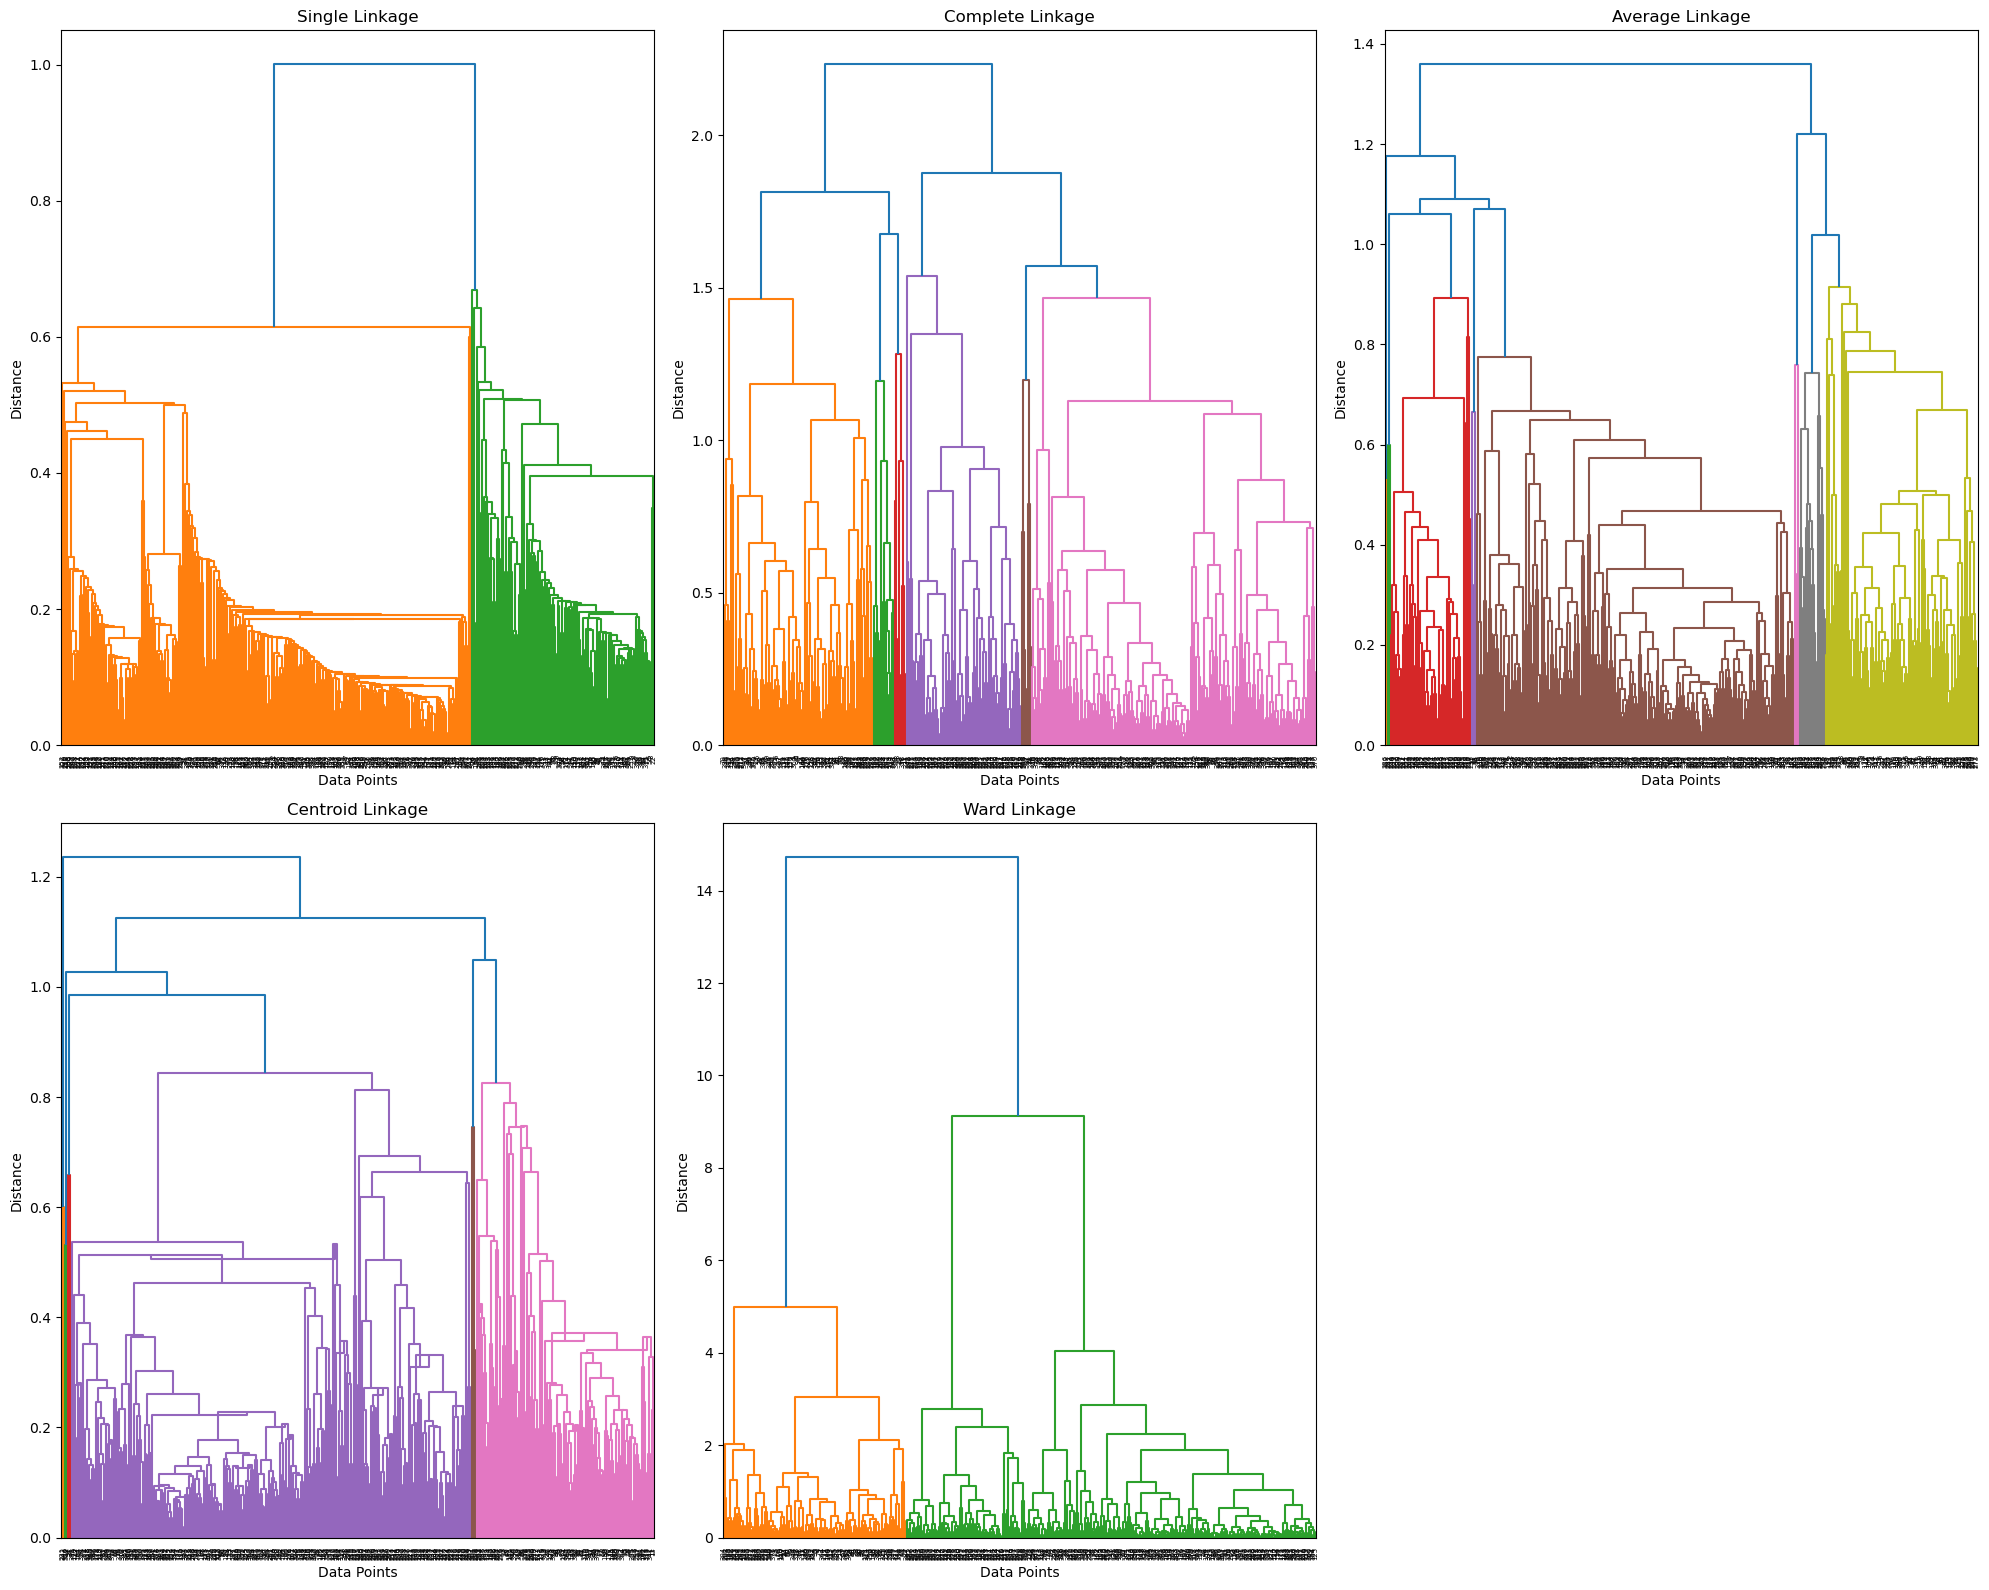

In [25]:
# Determine the ideal number of clusters to use with AgglomerativeClustering by plotting a Dendrogram

# Plot a dendrogram for each linkage method
methods = ['single', 'complete', 'average', 'centroid', 'ward']
linkages = {method: linkage(scaled_sales, method=method) for method in methods}

# Plot dendrograms for each linkage method
plt.figure(figsize=(20, 16))
for i, method in enumerate(methods, start=1):
    plt.subplot(2, 3, i)
    dendrogram(linkages[method])
    plt.title(f'{method.capitalize()} Linkage')
    plt.xlabel('Data Points')
    plt.ylabel('Distance')

plt.tight_layout()
plt.show()

From the plots above, mainly "Ward" and "Complete" linkages, it appears the ideal number of clusters is 4, resulting in Distances of around 4.5 and 1.75 respectively. For the rest of the analysis, 4 clusters and "Ward" linkage will be used.

In [71]:
# Fit the scaled dataset using AgglomerativeClustering with n_clusters=4, metric='euclidean' and linkage='ward'
agg_sales = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agg_sales.fit(scaled_sales)

# Count the number of points in each cluster
clust_labels = agg_sales.fit_predict(scaled_sales)
clust_counts = pd.Series(clust_labels).value_counts().sort_index()

# Create a dataframe to find the values of the cluster averages
df = pd.DataFrame(scaled_sales, columns=sales.columns)
df['Cluster_Labels'] = clust_labels

# Reverse scaling of cluster average values
clust_unscaled = scaler.inverse_transform(df.groupby('Cluster_Labels').mean())

# Create a new dataframe containing the average value and counts for every cluster
AggClust_df = pd.DataFrame(clust_unscaled, columns=sales.columns)
AggClust_df['Count'] = clust_counts.values
AggClust_df['Percent'] = (AggClust_df['Count'] * 100) / AggClust_df['Count'].sum()
AggClust_df.index.name = 'Cluster_Labels'
AggClust_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen,Count,Percent
Cluster_Labels,,,,,,,,,,
0,1.0,3.000000,12160.352041,3042.173469,3486.183673,2669.979592,756.326531,1098.443878,196,48.756219
1,2.0,3.000000,9200.659574,8343.648936,13346.000000,1386.031915,5528.500000,1498.680851,94,23.383085
2,1.0,1.304878,12095.939024,3116.536585,3941.182927,2836.073171,816.634146,1031.597561,82,20.398010
3,2.0,1.533333,6361.400000,8646.233333,13786.966667,2010.200000,6137.033333,1307.233333,30,7.462687


Similarly to KMeans, AgglomerativeClustering generated one large cluster containing 49% of the dataset, 2 medium clusters, each containing 20-23% of the dataset, and a small cluster containing 7% of the dataset. The average value for each cluster can be seen in the dataframe above. Now we can compare the performance of AgglomerativeClustering vs KMeans by computing its Silhouette score.

In [72]:
# Calculate Silhouette score for AgglomerativeClustering results
silh_score = silhouette_score(scaled_sales, agg_sales.labels_)
print(f'Silhouette Score: {silh_score}')

Silhouette Score: 0.4456488266825379


AgglomerativeClustering results in a small improvement of the Silhouette Score compared to KMeans, 0.45 vs 0.35

Now we can proceed to find which features of the dataset are the most relevant for clustering, using PCA

# Part IV - PCA

In this section you are going to perform principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

In [120]:
# Since the initial dataset comprises 8 features, we aim to employ PCA with a specified n_component = 4 to reduce the number of features by half.
sales_pca = PCA(n_components=4)
sales_pca.fit(scaled_sales)

# Transform the dataset to the new features
sales_pca_transformed = sales_pca.transform(scaled_sales)

# Create a new dataframe with the transformed data
sales_pca_df = pd.DataFrame(data=sales_pca_transformed, columns=[f'PC{i+1}' for i in range(sales_pca.n_components_)])
sales_pca_df

,PC1,PC2,PC3,PC4
0,0.700724,-0.161570,-0.031882,-0.153684
1,0.729681,-0.149648,0.052701,-0.079411
2,-0.364444,-0.262924,0.282101,-0.018816
3,0.632372,-0.177241,0.585109,-0.081591
4,0.649192,-0.169805,-0.030834,-0.208180
...,...,...,...,...
397,-0.226867,-0.255769,-0.101682,0.117756
398,-0.408634,-0.287902,0.436677,-0.119174
399,1.209279,-0.060553,0.064822,0.480766
400,-0.320620,-0.276353,-0.035558,0.098207


Now let's analyze the output of PCA

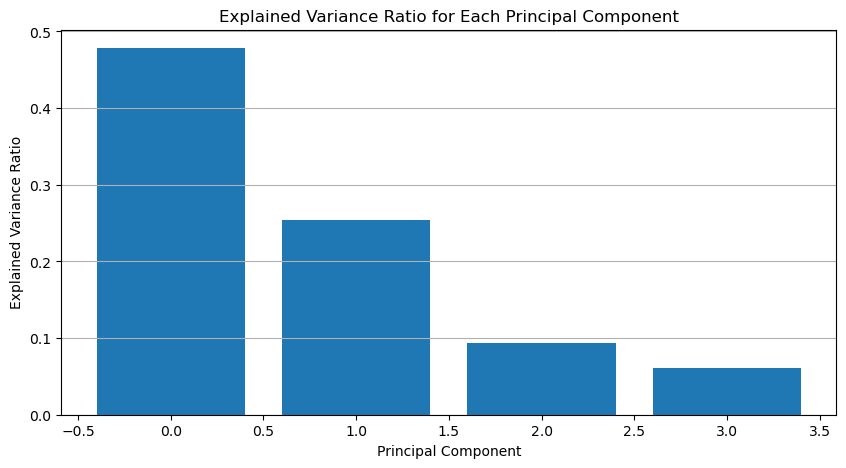

In [121]:
# Calculate explained variance for each principal component
explained_variance = sales_pca.explained_variance_ratio_

# Plot the explained variance
plt.figure(figsize=(10, 5))
plt.bar(range(len(explained_variance)), explained_variance)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(axis='y')

plt.title('Explained Variance Ratio for Each Principal Component')
plt.show()

In [122]:
# Retrieve the PCA components and create a dataframe to display feature coefficients for each principal component

# Create an empty dataframe with the required columns
n_components = 4
PCA_coef = pd.DataFrame(index=range(n_components), columns=sales.columns)

components = sales_pca.components_
n_features = len(sales.columns)
pc=[]

# Retrieve the coefficients for each feature and store them in the dataframe
for i in range(n_components):
    pc.append(i+1)
    indices = components[i].argsort()[::-1]
    top_features = [sales.columns[j] for j in indices]
    top_coef = components[i][indices]
    
    for j in range(n_features):
        PCA_coef.at[i, top_features[j]] = top_coef[j]

PCA_coef['Principal Component']=pc
PCA_coef.set_index('Principal Component', inplace=True)
PCA_coef

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Principal Component,,,,,,,,
1,0.851435,0.117233,-0.074168,0.234401,0.281768,-0.110879,0.323159,0.068926
2,0.080772,-0.991004,-0.028939,0.050517,0.055248,0.024876,0.065357,-0.007407
3,0.056648,0.010642,0.479972,0.142494,0.03263,0.698845,-0.042628,0.504712
4,-0.460505,0.028205,-0.29036,0.492888,0.362991,-0.187002,0.302479,0.449073


As seen on the bar chart above, the generated Principal Component #1 for almost half of the variance of the original dataset, and in turn the features "Milk", "Grocery", "Detergents_Paper", and especially "Channel" have the highest coefficients, indicating a strong relationship between these original features and the Principal Component #1. Interestingly, these are the same features for which we identified strong correlations during EDA.

Finally, we can evaluate the performance of PCA by calculating its Reconstruction Error

In [123]:
# Reverse the PCA transformation to the original scaled_sales dataset 
sales_reconstructed = sales_pca.inverse_transform(sales_pca_transformed)

# Calculate the reconstruction error
reconstruction_error = mean_squared_error(scaled_sales, sales_reconstructed)
print(f"Reconstruction Error: {reconstruction_error:.4f}")

Reconstruction Error: 0.0083


A reconstruction error of 0.0083 indicates that the information lost during the PCA process is minimal and that the 4 components generated adequately capture the essential information from the original dataset.

# Part V - Conclusion

From the model you developed and the exploratory data analysis (EDA) conducted, generate four bullet points as your findings.

• There is a strong correlation between features "Milk", "Grocery", "Detergents_Paper", and "Channel" and they account for most of the variation in the dataset. These correlations have the potential to effectively distinguish between customer segments and understand their purchasing patterns. Moreover, these strong associations can aid in minimizing computational demands for Market Basket analysis and enhancing revenue through targeted promotions and coupons.

• AgglomerativeClustering seems better suited for clustering this dataset, evident from its ability to yield a higher silhouette score with fewer clusters compared to KMeans.

• PCA revealed that a reduced set of four principal components can explain a significant portion of the variance in the original dataset. These components, especially the first one, captured a substantial amount of information, mainly influenced by the features "Milk," "Grocery," "Detergents_Paper," and "Channel."

• At the start of this project, it was tempting to drop features "Channel" and "Region" as they seemed less connected to the other features. However, PCA analysis revealed the significance of the feature "Channel" within this dataset, suggesting that discarding it would have been an incorrect decision.